# Confidence Regions Workshop OHBM 2023
## Beyond Blobology: Advances in Statistical Inference for Neuroimaging



Welcome to the Confidence Regions Workshop at OHBM 2023! This workshop will introduce you to the concept of Confidence Regions (CRs) and how they can be used to make inferences about brain activity. The session shall cover the generation of CRs for excursion sets derived from %BOLD maps, and demonstrate CRs using a range of examples. By the end of this workshop, you will have a better understanding of the following:

- What CRs are, both conceptually and mathematically.
- When you may want to use CRs, and why.
- The factors that influence the size and shape of CRs.
- Common pitfalls of CR interepretation.
- What software is available to generate CRs, and how to use it.

In this notebook, we will discuss CRs in the context of the recent debate about the use of null-hypothesis significance testing (NHST) in neuroimaging, and explain how CRs can be used to complement NHST. We shall also consider extensions of the CR method to other types of data, such as effect size images and conjunctions.

If you have any questions during this session, please feel free to ask me in person at any time, or reach out via email at [TomMaullin@gmail.com](mailto:TomMaullin@gmail.com). An anonymous feedback form is also available [here](https://forms.gle/n5yZ4N9UdQnCVCnJ8).

## Table of Contents

 - [Installation](#installation)
 - [Background](#background)
 - [Why use Confidence Regions? Confidence Regions vs Null Hypothesis Testing](#why-use-confidence-regions-confidence-regions-vs-null-hypothesis-testing)
 - [What are Confidence Regions?](#what-are-confidence-regions)
 - [What are Confidence Regions Not?](#what-are-confidence-regions-not)
 - [Under the Hood: How are Confidence Regions Generated?](#under-the-hood-how-are-confidence-regions-generated)
 - [2D Example](#2d-example)
 - [3D fMRI Simulated Example](#3d-fmri-simulated-example)
 - [3D fMRI Real Data Example](#3d-fmri-real-data-example)

### Installation

To get started, let's install the necessary software.

In [1]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install nilearn
%pip install nibabel
%pip install pyyaml
%pip install nbformat
%pip install scikit-image
%pip install plotly

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.



And import the necessary packages.

In [2]:
# Basic imports
import os
import numpy as np
from matplotlib import pyplot as plt

# Imports from Confidence Regions Toolbox
from generate import generate_CRs
from coverage import check_violations

# Import supporting functions
from lib.set_theory import *
from lib.boundary import *
from lib.regression import *

# Import data generation
from tests.generate_2d_data import *
from tests.generate_ni_data import *

# Import plotting functions
from lib.display import display_crs, display_volume

### Background

In this notebook, we will start by considering a *signal plus noise* model of the form:

$$Y(s)=\mu(s)+\epsilon(s), \quad \epsilon(s)\sim N(0,\sigma^2(s)I_n)$$

Here $s$ is a spatial location (e.g. an $(x,y,z)$ coordinate for a point in the brain), $\mu$ is the signal we are interested in estimating (e.g. %BOLD response), $Y$ is our data, and $\epsilon$ is the random noise. Many conventional fMRI analyses fall into this framework, most notably a standard group-level linear regression, which we shall consider later in this notebook. Our interest lies in estimating the *excursion set* $\mathcal{A}_c$, defined as:

$$\mathcal{A}_c:=\{s: \mu(s)\geq c\}$$

Here $c$ is a predefined threshold (for instance, $c= 1$\%BOLD change). In the context of fMRI group-level analysis, this set may represent the regions of the brain for which \%BOLD response exceeded a predefined amount. We will be investigating this set using Confidence Regions, which will be denoted $\hat{\mathcal{A}}_c^{+}$ and $\hat{\mathcal{A}}_c^{-}$. 
<div>
<img src="./demo/figs/excursion_sets.png" width="700"/>
</div>

> **Note:** We assume that we have i.i.d. observations for each subject, but we do not make any assumptions on the *spatial covariance* of our images.

Given an estimate of $\mu$, denoted $\hat{\mu}$ and derived from $Y$, our aim is to asssess how reliable our estimate of the excursion set, $\mathcal{A}_c$, is. Here, our estimate, $\hat{\mathcal{A}}_c$ is given by:

$$\hat{\mathcal{A}}_c=\{s:\hat{\mu}(s)\geq c\}$$

> **Note:** In the following sections, both $\mathcal{A}_c$ and $\hat{\mathcal{A}}_c$ will be displayed in yellow in figures. Make sure to double check which set you are looking at in the following figures.

To make this more concrete, let's look at some example data. For demonstrative purposes, this data is simulated, but it is designed to roughly resemble what might be seen in reality. Here is the simulated %BOLD response for a single subject.

In [3]:
# Read in some example data
Y_instance = os.path.join(os.getcwd(),'demo','data','example1','Data_Instance_Example1.nii.gz')

# Display the Y instance using the display_volume function
display_volume(Y_instance)

KeyboardInterrupt: 

 > **Developer's Note:** If you can only see an empty display with a slider in your Jupyter notebook, try clicking on the slider to see if anything changes. If this doesn't work for you, or the slider isn't appearing at all, try setting `display` to `simple` and enter the `slice` you wish to view as shown below.

In [ ]:
display_volume(Y_instance, display='simple', slice=60)

> **Developer's note:** Viewing NIFTI images can be computationally intensive. For the best performance when running this notebook, we recommend never having too many interactive NIFTI displays open at once. Once you have had a look at a NIFTI in interactive mode, it may be best to choose a slice you like and change the display to a simple display for that slice before moving on.

In the model we gave above, if $s$ is the location of voxel, $Y(s)$ would be the $(n \times 1)$ vector obtained by stacking together the values observed at $s$ in each of the $n$ observed images.

<div>
<img src="./demo/figs/bold_y.png" width="700"/>
</div>

Here is the signal $\mu$ used to generate this data. $\mu$ consists of a single large cluster of activation, somewhere inside the parietal lobe.

In [ ]:
# Read in some mu
mu_file = os.path.join(os.getcwd(),'demo','data','example1','True_Signal_Example1.nii.gz')

# We'll add a mask as a background to help visualise the data
mask_file = os.path.join(os.getcwd(),'demo','data','mask.nii.gz')

# Display mu using the display_volume function
display_volume(mu_file, bg = mask_file)

In this example, we will be aiming to estimate the region where $\mu > c$. This is shown below.

In [ ]:
# This is our binary set we wish to estimate
Ac_file = os.path.join(os.getcwd(),'demo','data','example1','True_Ac_Example1.nii.gz')

# We'll add a mask as a background to help visualise the data
mask_file = os.path.join(os.getcwd(),'demo','data','mask.nii.gz')

# Display mu using the display_volume function
display_volume(Ac_file, bg = mask_file)

In the next few sections, we shall use the above mock example to demonstrate some basic properties of CRs.

### Why use Confidence Regions? Confidence Regions vs Null Hypothesis Testing

Before going further, it is worth briefly discussing why you may be interested in using CRs instead of, say, conventional Null Hypothesis Significance Testing. NHST is a staple of fMRI anlaysis. However, it is not without it's problems. These include, for instance:

- The *"Null hypothesis fallacy"*; the problem that even trivial effects can be determined as significant when testing $H_0:\mu=0$.

- Significance values are arbitrarily chosen but crucial to the analysis interpretation (*"Surely, God loves the .06 nearly as much as the .05." Robert Rosenthal, 1979* [[1]](https://psycnet.apa.org/record/1979-27602-001)).

- Observing that an effect is non-zero effect does not provide any information about the size of the effect. 

- Studies can fail to reject the null hypothesis due to limited statistical power rather than evidence in favour of the null hypothesis.

These criticims have been repeatedly raised in the statistics literature for over 70 years, and are still applicable to many of the fMRI analyses conducted today. A good summary of the prevailing viewpoint is given by the American clinical psychologist Paul E. Meehl [[2]](https://meehl.umn.edu/sites/meehl.umn.edu/files/files/169problemisepistemology.pdf): 

> *"The Problem Is Epistemology, Not Statistics: Replace Significance Tests by Confidence Intervals and Quantify Accuracy of Risky Numerical Predictions"*

The same comment applies in higher dimensions; *"Replace (or at least complement) Significance Tests with Confidence Intervals and Effect Sizes"*.

### What are Confidence Regions?

Conceptually, CRs are similar to confidence intervals but, instead of upper and lower bounds for a scalar parameter, they provide estimated inner and outer sets, $\hat{\mathcal{A}}_c^{+}$ and $\hat{\mathcal{A}}_c^{-}$, to bound an excursion set $\mathcal{A}_c$. When we see wide confidence intervals for a scalar parameter estimate, this suggests that the procedure which produced the estimate is not very reliable.


<div>
<img src="./demo/figs/confidence_intervals.png" width="600"/>
</div>


Similarly, when we see CRs which exhibit little resemblance to one another, this is typically interpreted as a lack of reliability in the estimation of the excursion set. In other words, tight resemblance means the procedure used to estimate the excursion set is realiable.


<div>
<img src="./demo/figs/confidence_regions.png" width="600"/>
</div>

Mathematically, for a tolerance level $\alpha$, CRs are sets designed satisfy the following expression:

$$\mathbb{P}[\hat{\mathcal{A}}^{+}_c\subseteq\mathcal{A}_c\subseteq\hat{\mathcal{A}}^{-}_c]=1-\alpha \quad \quad \quad (1)$$

Conventional tolerance levels tend to include $\alpha=0.1,0.05$ and $0.01$ ($10$\%, $5$\% and $1$\%). Throughout this notebook, unless stated otherwise we shall used $\alpha=5\%$.

When displaying CRs, we will always show the inner set ($\hat{\mathcal{A}}_c^{+}$) in red, the outer set ($\hat{\mathcal{A}}_c^{-}$) in blue and the point estimate ($\hat{\mathcal{A}}_c$) in yellow. For the CRs we will be generating, it follows from the construction we will use that the sets $\hat{\mathcal{A}}_c^{+}$, $\hat{\mathcal{A}}_c$ and $\hat{\mathcal{A}}_c^{-}$ will always be nested within one another (as opposed to the set $\mathcal{A}_c$ which will lie between $\hat{\mathcal{A}}_c^{+}$ and $\hat{\mathcal{A}}_c^{-}$ in $(1-\alpha)$\% of future experiments).

Let's load in some pre-computed CRs to see what this might look like for fMRI data.

In [ ]:
# Load in pre-computed confidence regions.
Upper_CR_fname = os.path.join(os.getcwd(),'demo','data','example1','Upper_CR_Example1.nii.gz')
Lower_CR_fname = os.path.join(os.getcwd(),'demo','data','example1','Lower_CR_Example1.nii.gz')

# Load in a pre-computed point estimate of Ac.
estimated_Ac_fname = os.path.join(os.getcwd(),'demo','data','example1','Estimated_Ac_Example1.nii.gz')

# Load in a pre-computed mask.
mask_fname = os.path.join(os.getcwd(),'demo','data','mask.nii.gz')

# Display confidence regions in interactive slice plot.
display_crs(estimated_Ac_fname, Upper_CR_fname, Lower_CR_fname, mask_fname, mode='Sagittal')

 > **Developer's Note:** As with the `display_volume` function, if you can only see an empty display with a slider in your Jupyter notebook, try clicking on the slider to see if anything changes. You can also `display` to `simple` and enter the `slice` you wish to view as shown below.

In [ ]:
# Display confidence regions in non-interactive slice plot.
display_crs(estimated_Ac_fname, Upper_CR_fname, Lower_CR_fname, mask_fname, mode='Sagittal', display='simple', slice=60)

These CR's were generated using $B=5000$ bootstrap instances. By the end of this notebook, you will have made your own CRs using both 2D and 3D synthetic data, as well as for a real-data example.

> **Test your understanding:** The images we have looked at so far can all be found in the `./demo/data/example1` folder. Another set of CRs can be found in `./demo/data/example2` folder under similar filenames. Using the functions described above, have a look at these files. If these were your analysis results, which CRs do you think would be preferable to observe? And why?

In [ ]:
# Write your code here...

### What are Confidence Regions **not**?

As with confidence intervals, it is very easy to misinterpet the definition of Confidence Regions. A common reason for misinterpretation is confusion over which sets are random and which are fixed. Here are some common **incorrect interpretations** of CRs:

 - If we generate a pair of 95\% CRs $\hat{\mathcal{A}}^{+}_c$ and $\hat{\mathcal{A}}^{-}_c$, this  **does not** mean that there is a 95\% probability $\mathcal{A}_c$ is nested between the particular CRs that we have generated. This is because $\mathcal{A}_c$ is a fixed (non-random) set, and once we know the values of $\hat{\mathcal{A}}^{+}_c$ and $\hat{\mathcal{A}}^{-}_c$, they also are fixed. This means that, for any given pair of CRs, the probability of $\mathcal{A}_c$ lying between them must be zero or one. 
 - A pair of 95\% CRs **do not** 'contain' the excursion set for individual subjects (e.g. $\{s: Y_k(s)\geq c\}$ for subject $k$) 95\% of the time.
 - A given pair of 95\% CRs, generated from a single run of the method, **will not** 'contain' the estimated excursion set $\hat{\mathcal{A}}_c$ in 95\% of replications.

Here are some **correct interpretations**:

 - If the 95\% CR generating procedure were repeated on numerous samples, the proportion of CRs, $\hat{\mathcal{A}}^{+}_c$ and $\hat{\mathcal{A}}^{-}_c$, that correctly enclose $\mathcal{A}_c$ would tend to 95\%.
 - There is a 95\% probability that the region $(\hat{\mathcal{A}}^{+}_c)^c \cap \hat{\mathcal{A}}^{-}_c$, in a future experiment, fully encompasses the boundary of $\mathcal{A}_c$.
 - In the fMRI context, within a 95\% upper CR (red set) we can assert with 95\% confidence that there has been (at least) a c\% change in BOLD response. Similarly, within the 95\% lower CR (blue set), we can assert with 95\% confidence that there has been (at most) a c\% change in BOLD response.

### Under the Hood: How are Confidence Regions Generated?

*This notebook is designed to be practical, rather than mathematical. However, for those interested in understanding how we generate CRs this section provides a brief overview. If you are not interested in the math, this section can be safely skipped and you should feel free to move ahead to 2D example.*

Many authors have suggested methods for generating CRs which satisfy Equation $(1)$. Here are some very brief summaries of commonly employed CR generation methods:

- Empirically estimate the distribution of the [Hausdorff distance](https://en.wikipedia.org/wiki/Hausdorff_distance) between $\mathcal{A}_c$ and $\hat{\mathcal{A}}_c$ and then generate CRs by 'fattening' $\hat{\mathcal{A}}_c$ using the $(1-\alpha)$ quantile of this distribution (see [[3]](https://doi.org/10.1080/01621459.2016.1228536) for further detail).
- Represent the excursion sets using a parametric family and apply a sequential importance sampling method for estimating joint probabilities (see [[4]](http://www.jstor.org/stable/24774726)). 
- Using properties of the noise process along the boundary of $\mathcal{A}_c$, assess the probability of $\hat{\mathcal{A}}^{+}_c\subseteq\mathcal{A}_c\subseteq\hat{\mathcal{A}}^{-}_c$ holding (see [[5]](https://doi.org/10.1080/01621459.2017.1341838)).

The latter method is our favoured approach, and the one which is employed throughout this notebook, so we will explain it in a little more detail. This approach was originally described in the paper ["Confidence Regions for Spatial Excursion Sets From Repeated Random Field Observations, With an Application to Climate (2017)"]((https://doi.org/10.1080/01621459.2017.1341838)), which we shall refer to as SSS for short after the second initials of the authors; Max Sommerfeld, Stephan Sain & Armin Schwartzman. 

In SSS, the spatial domain (e.g. the brain in fMRI) we are working in is denoted as $S$, and a functional central limit theorem of the following form is assumed:
\begin{equation}\nonumber
\bigg\{\frac{\hat{\mu}(s) - \mu(s)}{\sigma(s)/\sqrt{n}}\bigg\}_{s \in S} \to \big\{G(s)\big\}_{s \in S} \quad \text{as }\quad n \rightarrow \infty.
\end{equation}
Here, $G$ is a well-defined random field on $S$ with almost surely continuous sample paths. The notation $G$ is indicative of the fact that in many practical instances, $G$ is a Gaussian random field with mean zero and unit pointwise variance (with no assumed spatial covariance). To generate CRs, however, we do not require any such distributional assumptions.

SSS then assumes that CRs are constructed as follows:
\begin{equation}\nonumber
    \hat{\mathcal{A}}_c^{\pm}=\bigg\{s \in S : \frac{\hat{\mu}(s)-c}{\hat{\sigma}(s)/\sqrt{n}} \geq \pm q\bigg\}
\end{equation}
for some quantile $q \in \mathbb{R}$ which must be estimated empirically. In SSS, it was shown, under minor assumptions which guarantee that the topology of $\mu$ does not change at the level $c$, that:
\begin{equation}\nonumber
\lim_{n \rightarrow \infty}\mathbb{P}[\hat{\mathcal{A}}^{+}_c\subseteq\mathcal{A}_c\subseteq\hat{\mathcal{A}}^{-}_c]=\mathbb{P}\bigg[\sup_{s \in \partial \mathcal{A}_c} |G(s)|\leq q \bigg] \quad \quad (2)
\end{equation}
where $\partial \mathcal{A}_c$ is the boundary of $\mathcal{A}_c$, assumed to be equal to the level set $\{s \in S: \mu(s)=c\}$.

> **Developer's note:** You can create images of $\partial\mathcal{A}_c$ in the CR toolbox using the `get_bdry_map_combined` function, shown below. It is worth clarifying that we only use the boundary 'inside' the brain mask (see slice 60) - the edge of the brain mask does not count as part of $\partial\mathcal{A}_c$.

In [ ]:
# Read in true Ac
true_Ac_fname = os.path.join(os.getcwd(),'demo','data','example1','True_Ac_Example1.nii.gz')

# Generate boundary map
Ac_bdry = get_bdry_map_combined(true_Ac_fname, mask=mask_fname)

# Display boundary map
display_volume(Ac_bdry, bg = mask_fname)

The important point to note here is that, to generate CRs which satisfy Equation $(1)$ asymptotically, we only need to find a value $q$ such that the right hand side of $(2)$ equals $(1-\alpha)\%$. In other words, we need to find the $(1-\alpha)\%$ quantile of the distribution of $\sup_{\partial \mathcal{A}_c} |G(s)|$. To find this quantile, we perform a wild $t$-bootstrap procedure proposed by [[6]](https://doi.org/10.1016/j.neuroimage.2019.116187) using the standardized residual images from a linear regression.

To summarize:

- SSS CRs are generated as excursion sets of $\frac{\hat{\mu}(s)-c}{\hat{\sigma}(s)/\sqrt{n}}$ using a quantile $q$.
- The probability that SSS CRs are correctly nested is asymptotically equal to the probability that $\sup_{\partial \mathcal{A}_c} |G(s)|\leq q$.
- We can choose $q$ to satisfy $\mathbb{P}[\sup_{\partial \mathcal{A}_c} |G(s)| \leq q]=1-\alpha$ by performing a Wild-$t$ bootstrap using the standardized residuals from a regression.

To make things more concrete, let's now turn to some examples.

### 2D Example

CR generation requires boostrapping, which is a time and memory consuming process. Before we look at fMRI analyses with large images containing hundreds of thousands of voxels, let's first use a toy example with 2D images to investigate some features of confidence regions.

We'll begin by creating a toy dataset of 100 2D images. To begin, let's create a 2D signal, $\mu$. We have prepared three example $\mu$ signals you can use in this section; a circle, square and ramp signal. Here is an example of a circular signal.

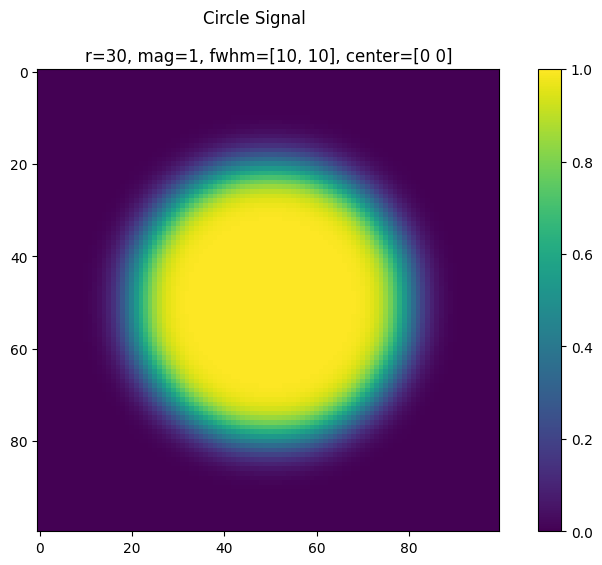

In [11]:
# This command will define a circular smooth signal
circle_signal = CircleSignal(r=30, fwhm=[10,10], mag=1)

# Once we have defined a signal we can plot the output like so:
circle_signal.plot()

You can change the following properties when defining your circle signal:

 - `r`: This is the radius of the circle.
 - `mag`: This is the magnitude of the signal (signal height).
 - `fwhm`: The full width half maximum representing the smoothness of the image (this must be a list containing a smoothness value for each dimension e.g. `[4,5]`).
 - `center`: This is where the circle is centered with `[0,0]` representing the center of the image (this must be a list containing a coordinate for each dimension e.g. `[10,10]`).
 - `dim`: This is the image dimensions (by default `[100,100]`). As we may generate a lot of images, it would be advisable not to make these dimensions larger than this for now.

You can also generate a square signal as follows:

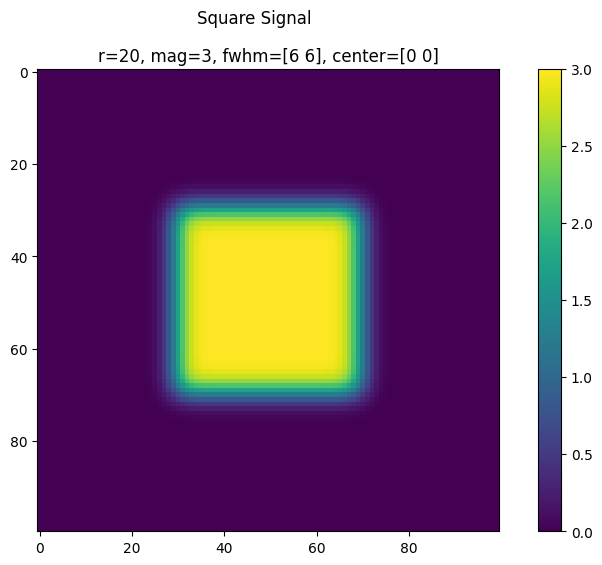

In [12]:
# This command will define a smooth square signal
square_signal = SquareSignal(r=20)

# Once we have defined a signal we can plot the output like so:
square_signal.plot()        

The options for square signal generation are identical to those of a circle.

To generate a linear ramp signal you can use the following code:

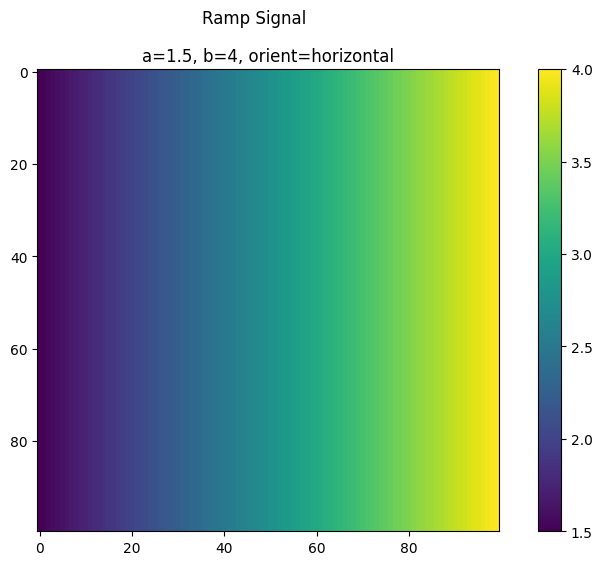

In [13]:
# This command will define a linear ramp signal
ramp_signal = RampSignal(a=1.5,b=4)

# Once we have defined a signal we can plot the output like so:
ramp_signal.plot()

To generate a ramp you have the following options:

- `a`: The magnitude at the lower end of the ramp.
- `b`: The magnitude at the higher end of the ramp.
- `orient`: The orientation of the ramp (`vertical` or `horizontal`).

Choose the signal you want to use for this section below:

In [14]:
my_signal = # Write your code here...

SyntaxError: invalid syntax (1000096993.py, line 1)

Once you've decided on the $\mu$, we need to define the noise field, $\epsilon$. To do this, you can use the following code.

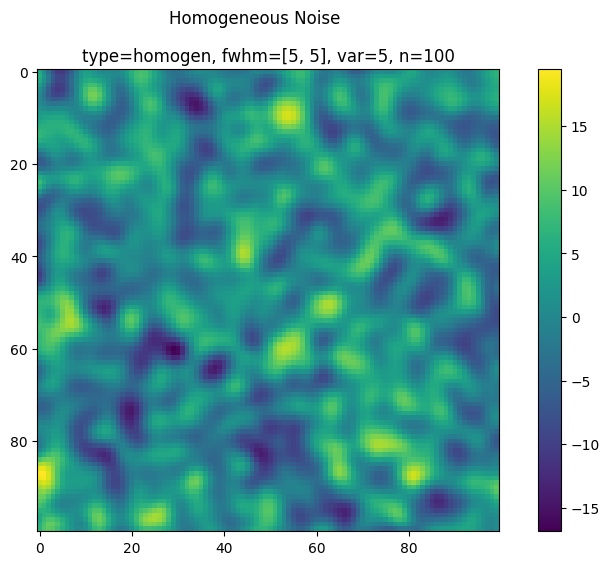

In [15]:
# Specify the noise
noise = Noise(var=5,fwhm=[5,5])

# Plot a single realisation of the noise
noise.plot()


To generate noise you can use the following options:
- `type`: Type of noise to generate. Can be `homogen` (homogeneous) or `heterogen` (a heterogenous linear ramp).
- `fwhm`: fwhm of smoothing kernel.
- `var`: Variance of noise.
- `dim`: Dimensions of image.
- `n`: Number of observations to generate (default is set to `100`).

Choose the noise you want to use for this section below:

In [16]:
my_noise = # Write your code here...

SyntaxError: invalid syntax (38899214.py, line 1)

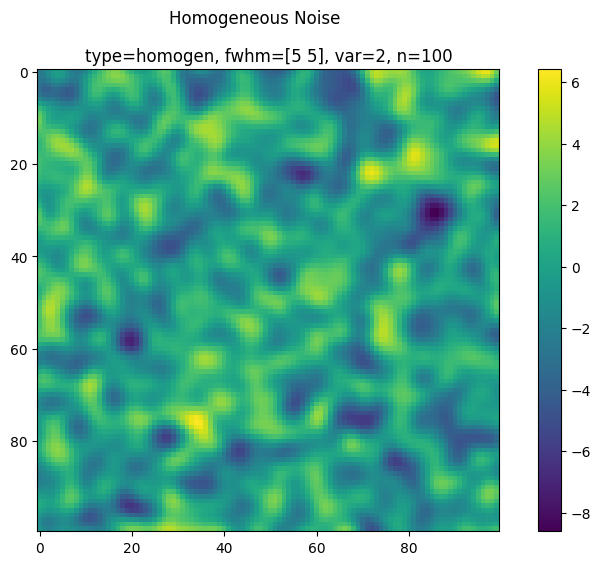

In [17]:
# MARKER
my_noise = Noise(var=2)
my_signal = CircleSignal(r=20, mag=3)
my_noise.plot()

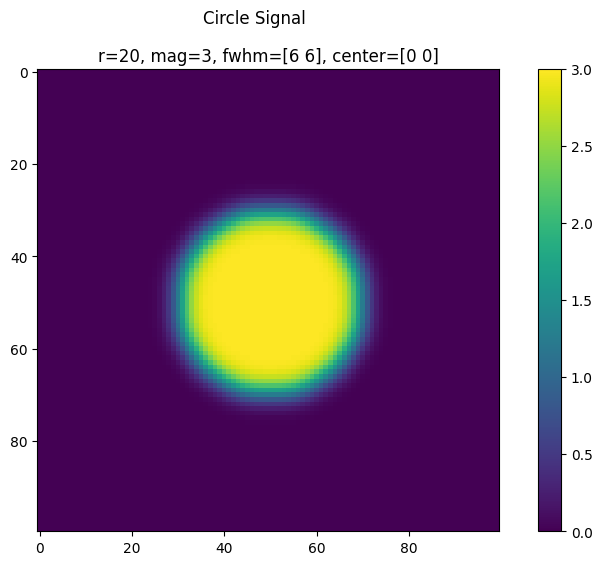

In [18]:
# MARKER
my_signal.plot()

Using these objects, we shall now generate some test data to investigate.

In [19]:
# Output directory (feel free to change this to your desired output directory)
out_dir = os.path.join(os.getcwd(),'demo','data','example_2D')

# We can generate some 2D data using the generate_data_2D function
data_files, mu_file = generate_data_2D(my_signal, my_noise, out_dir=out_dir)

# Let's record the number of observations; this will be useful later
n = len(data_files)

You can look at these files using the same `display_volume` function as before, like so:

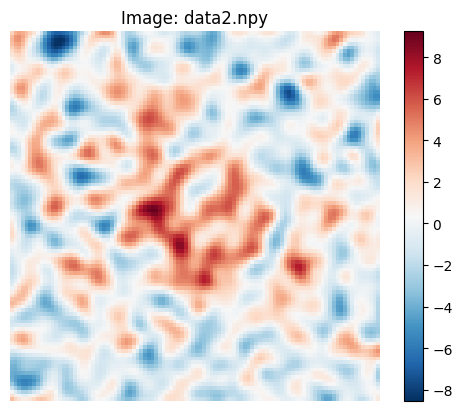

In [20]:
# We can visualise the data using the functions we have already seen.
display_volume(data_files[2])

We've succesfully generated some data. Our aim now is to estimate the excursion set $\mathcal{A}_c$, and generate confidence regions for it. As this is a simulation, we know $\mu$ and can look at the true excursion set, $\mathcal{A}_c$.

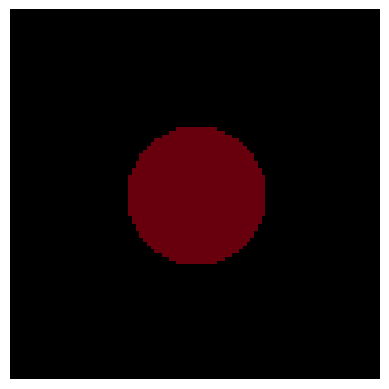

In [21]:
# Choose a threshold c
c = 2

# Read mu from file
mu = read_image(mu_file)

# Create boolean map of Ac
Ac = mu>c

# Display Ac
display_volume(Ac)

To generate confidence regions, we will need a mean estimate ($\hat{\mu}$), a standard deviation estimate ($\hat{\sigma}$) and a residual image for each subject. We can do this using the `regression` function from the confidence regions toolbox.


In [22]:
# Construct a design matrix with only an intercept (this means that the parameter estimate from the regression will be the mean of the data)
X = np.ones((n,1))

# Fit the regression model
muhat_file, sigma_file, resid_files = regression(data_files, X, out_dir)

Let's see the mean estimate $\hat{\mu}$.

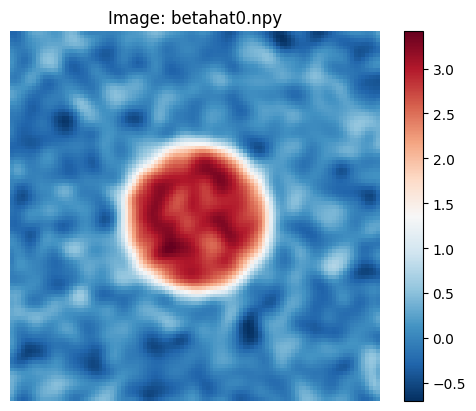

In [23]:
# Display the estimated mu
display_volume(muhat_file)

Our estimated excursion set, $\hat{\mathcal{A}}_c$, is given by:

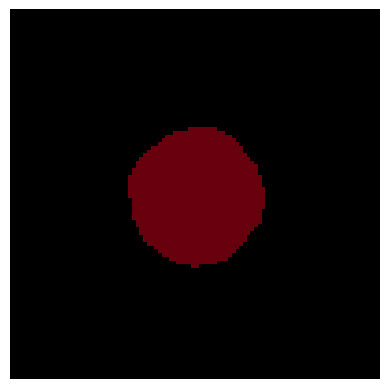

In [24]:
# Get the binary map for the estimated Ac
Ac_hat = read_image(muhat_file) > c

# Display the estimated excursion set
display_volume(Ac_hat)

Okay, so we have now generated some simulated data, obtained a group average and estimated our "region of activation". If this were a typical group-level fMRI analysis, to tell if this region was meaningful in some statistical sense, we would likely perform a T-test of some form. Here, we are going to instead compute confidence regions. We can do this like so:

In [25]:
# Decide a confidence level alpha
alpha = 0.05

# Generate confidence regions (to save time, we will use 2000 bootstrap iterations for now)
lower_cr_file, upper_cr_file, estimated_ac_file, quantile_estimate = generate_CRs(muhat_file, sigma_file, resid_files, out_dir, c, 1-alpha, n_boot=2000)

(100, 100, 1)


The outputs of the `generateCRs` file are:

- `lower_cr_file:` The filename of the file containing the lower confidence region, , $\hat{\mathcal{A}}^-_c$.
- `upper_cr_file:` The filename of the file containing the upper confidence region, $\hat{\mathcal{A}}^+_c$.
- `estimated_ac_file:` The filename of the file containing the estimated excursion set, $\hat{\mathcal{A}}_c$.
- `quantile_estimate:` The estimated quantile of the supremum probability given in Equation $(2)$.

Let's display the results.

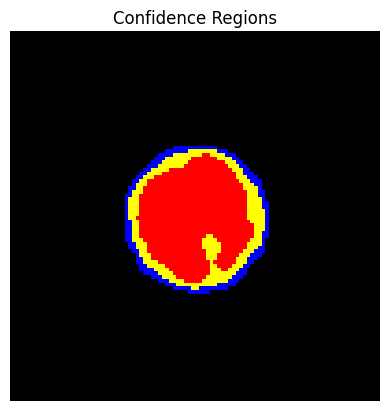

In [26]:
# Display the estimated mu
display_crs(estimated_ac_file, upper_cr_file, lower_cr_file)

 > **Test your understanding:** Congratulations, you've made some CRs! Now you have generated one set of CRs, try going back to signal and noise generation and test a few different options. What do you think impacts the observed CR 'resemblance'? Which variables make the CRs thinner or fatter? For instance, what are the effects of changing sample size, noise variance, smoothness and so forth?

In [27]:
# Write your code here...

While we have it in memory, let's have a quick look at the quantile estimates.

In [28]:
# Get number of quantile estimates
print(quantile_estimate[0])

3.3863562107086183


> **Test your understanding:** If you are interested in the math behind CRs, see if you can guess what `quantile_estimate` is in the notation of the `Under the hood: How are CRs generated?` section. If you are unsure, feel free to ask.

We can also use the `generate_crs` method to return more quantiles of the distribution of $\sup_{\partial\mathcal{A}_c}|G(s)|$. This is done by specifying an array of `alpha` values like so:

(100, 100, 1)


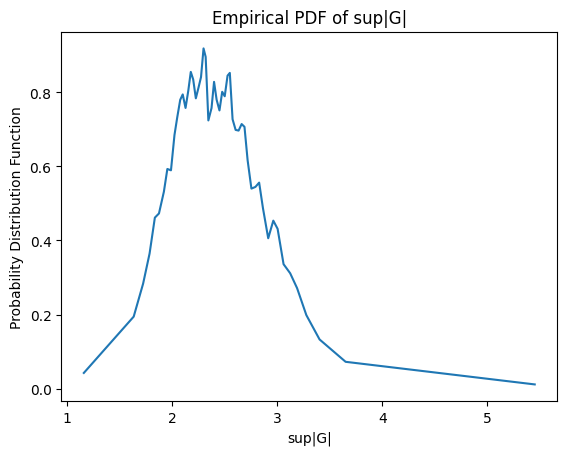

In [29]:
# List of alpha values
alphas = np.linspace(0,1,51)

# Generate quantiles (for time purposes we will only use 2000 bootstrap iterations for now)
_, _, _, quantile_estimates = generate_CRs(muhat_file, sigma_file, resid_files, out_dir, c, 1-alphas, n_boot=5000, output=False)

# Convert the CDF to a PDF (this is just done by taking the gradient of the CDF)
pdf = np.gradient(1-alphas, quantile_estimates)

# Plot the PDF of sup|G|
plt.plot(quantile_estimates, pdf)

# Add labels
plt.xlabel('sup|G|')
plt.ylabel('Probability Distribution Function')

plt.title('Empirical PDF of sup|G|')
plt.show()

> **Note:** In the above code, we set `output` to false to prevent CRs being output for every value of $\alpha$.

As a sanity check, we can assess the coverage of our confidence regions by using the `check_violations` function.

In [30]:
# TO DO...

# Set the number of repetitions (to begin this is set to 1)
nReps = 1000

# Get the number of observations
n = len(data_files)

# Get alpha
alpha = 0.05

# Loop through the repetitions
for j in np.arange(nReps):

    # Generate some new noise
    my_noise.generate()

    # Generate some new data
    data_files, mu_file = generate_data_2D(my_signal, my_noise, out_dir=out_dir)

    # Fit the regression model
    muhat_file, sigma_file, resid_files = regression(data_files, X, out_dir)

    # Generate Confidence Regions
    lower_cr_file, upper_cr_file, estimated_ac_file, quantile_estimate = generate_CRs(muhat_file, sigma_file, resid_files, out_dir, c, 1-alpha, n_boot=5000)

    # Get the results
    results = check_violations(upper_cr_file, lower_cr_file, muhat_file, sigma_file, mu_file, n, c, quantile_estimate)

    # Average the results
    if j == 0:
        concat_results = np.array(results[0])
    else:
        # Concatenate the results
        concat_results = np.concatenate((concat_results.reshape(1,np.prod(concat_results.shape)),
                                        results[0].reshape(1,np.prod(results[0].shape))),axis=1)

        # Avergae the results
        avg_results = np.mean(concat_results,axis=1)

        print('current avg: ', avg_results)


(100, 100, 1)
quantile  [3.38029307]
results:  (array([1], dtype=int32), {'Interp: ': array([ True]), 'Binary: ': array([1])})
(100, 100, 1)
quantile  [3.38057897]
results:  (array([1], dtype=int32), {'Interp: ': array([ True]), 'Binary: ': array([1])})
current avg:  [1.]
(100, 100, 1)
quantile  [3.3974951]
results:  (array([1], dtype=int32), {'Interp: ': array([ True]), 'Binary: ': array([1])})
current avg:  [1.]
(100, 100, 1)
quantile  [3.4111534]
results:  (array([1], dtype=int32), {'Interp: ': array([ True]), 'Binary: ': array([1])})
current avg:  [1.]
(100, 100, 1)
quantile  [3.36674185]
results:  (array([1], dtype=int32), {'Interp: ': array([ True]), 'Binary: ': array([1])})
current avg:  [1.]
(100, 100, 1)
quantile  [3.36829309]
results:  (array([0], dtype=int32), {'Interp: ': array([False]), 'Binary: ': array([1])})
current avg:  [0.83333333]
(100, 100, 1)
quantile  [3.35373032]
results:  (array([1], dtype=int32), {'Interp: ': array([ True]), 'Binary: ': array([1])})
current av

In [ ]:
# Display the estimated mu
display_crs(estimated_ac_file, upper_cr_file, lower_cr_file)

> **Test your understanding:** Try running the above with a few different signals and noise settings. Which factors (e.g. noise magnitude, sample size, smoothness) cause the observed coverage to differ from $1-\alpha$? Why do you think this is?

We are now ready to move to fMRI examples and regression. Before moving on, let's summarize some points from this section:

- Regression in the CR toolbox can be performed using the `regression` function.

- CRs can be generated using the `generate_crs` function.

- The 'tightness' of CR resemblance is influenced by a range of factors, including:

    - Sample size: Small samples result in more variable estimates.

    - Smoothness: If $\mu$ is very smooth, then small amounts of noise can have a strong impact on the shape of $\mathcal{A}_c$.

    - Excursion set size: If there is more to estimate, there is more room for error.

    - Noise magnitude: If there is larger noise, it will be harder to estimate the signal.

    - Noise heterogeneity: If the noise is larger in one part of an image than another, the CRs will reflect this.

- The performance of the CR method is robust to a range of factors including: the smoothness levels used, excursion set shape and size, choice of threshold $c$ (provided the $A_c$ is not a peak, minima or plateau), realistic variation in noise magnitude and heterogeneity in the noise. For small samples, however, some overcoverage may be observed.


If you want to clean up the files generated from this section, please use the below code.

In [ ]:
# List of files or file collections to remove
files_to_remove = [data_files, resid_files, mu_file, muhat_file, sigma_file, lower_cr_file, upper_cr_file, estimated_ac_file]

# Remove each file or file collection
for files in files_to_remove:
    remove_files(files)

### 3D fMRI Simulated Example

Now that we have investigated the behaviour of CRs on small 2D examples, we're ready to move to 3 dimensions! In this section, we will generate CRs for a simulated group-level fMRI analysis. 

To begin, let's generate some data.

> **Warning:** In this section, we will be generating nifti images, which are much larger than the `.npy` files we used for the 2D example. If you have limited space on your computer, please consider setting the sample size, `n`, (e.g. the number of images we are generating) and number of parameters, `p`, (e.g. the number of regression coefficients we are estimating) to small values in the below code.

In [ ]:
# Number of subjects
n = 30

# Number of parameters
p = 3

# Output directory (feel free to change this to your desired output directory)
out_dir = os.path.join(os.getcwd(),'demo','data','example_3D')

# Generate some test data
y_files, beta_files, X = generate_data(n, p, out_dir)

We have just generated some synthetic data according to the linear model:

\begin{equation}\nonumber
    Y(s) = X\beta(s) + \epsilon(s), \quad \epsilon(s)\sim N(0,\sigma^2(s)I_n)
\end{equation}

In this model $X$ is an $(n \times p)$ design matrix containing an intercept and $p-1$ uniformly generated mean zero columns and, for each spatial location (voxel) $s$: 
- $Y(s)$ is the $(n \times 1)$ response vector.
- $\beta(s)$ is the $(p \times 1)$ parameter vector.
- $\epsilon(s)$ is an $(n \times 1)$ random error vector.
- $\sigma^2(s)$ is a scalar error variance.

This simulated data is designed to resemble something like the group-level linear model illustrated below:
<div>
<img src="./demo/figs/glm2_nb.png" width="700"/>
</div>

Here, the signal we are interested in estimating is $\mu:=L'\beta$, where $L$ is a fixed and known $(1 \times p)$-sized contrast vector specifying some belief about the linear relationships between the elements of $\beta$. To keep things simple, in this example we will just be using $L=[1,0,...,0]$, meaning that $\mu=\beta_0$, the $\beta$ image corresponding to the intercept.

Let's have a quick look at some of the data we have just made. Here's an instance of the data.

In [ ]:
# Display the first Y image
display_volume(y_files[0])

Here is the $\beta$ map we will be investigating. This was generated using a circular signal of a random radius, placed randomly somewhere near the center of the image.


In [ ]:
# Mask file for background
mask_file = os.path.join(os.getcwd(),'demo','data','mask.nii.gz')

# Display the beta image we will be estimating
display_volume(beta_files[0], bg=mask_file)

Let's perform a regression to get the images we need. You can use the same `regression` function as in the 2D example to perform this step.

In [ ]:
betahat_files, sigma_file, resid_files = # Write your code here...

To save memory, you can now delete the `y_files` using the below code if you would like.

In [ ]:
# Boolean
you_would_like = True

# Delete files if you would like
if you_would_like:

    # Remove data files
    remove_files(y_files)

Let's have a quick look at our signal estimate, $\hat{\beta}_0$.

In [ ]:
# Display the estimated beta image
display_volume(betahat_files[0])

We are now in a position to generate some 3D CRs! We can do this as follows: 

> **Developer's Note:** As the 3D images are 100 times bigger than the 2D images, this might take a little more time to run!

In [ ]:
# Decide a confidence level alpha
alpha = 0.05

# To save time, we suggest using 2000 bootstrap iterations at first
n_boot = 2000

# Threshold c
c = 2

# Generate confidence regions
lower_cr_file, upper_cr_file, estimated_ac_file, quantile_estimate = generate_CRs(betahat_files[0], std_beta_files[0], resid_files, out_dir, c, 1-alpha, n_boot=n_boot)

Have a look at these CRs by writing some code in the box below.

In [ ]:
# Write your code here...

> **Test your understanding:** Compare these to the $\beta$ estimate we displayed above. What do these CRs tell you about the estimate?

Congratulations, you now know all you need to generate CRs in practice. In the next section, you will use what you have learnt to generate CRs for a real-world dataset!

In [ ]:
# If you would like to remove the files from this section set this to True
you_would_like = True

# Delete files if you would like
if you_would_like:

    # List of files or file collections to remove
    files_to_remove = [y_files, resid_files, betahat_files, beta_files, std_beta_files, lower_cr_file, upper_cr_file, estimated_ac_file]

    # Remove each file or file collection
    for files in files_to_remove:
        remove_files(files)

### 3D fMRI Real Data Example

In this section, it is up to you! The below code will download a real-world dataset for you.

In [ ]:
# waiting on data...

This dataset was derived from... \{dataset summary to go here\}. 

See if you can generate CRs for the contrast...

In [ ]:
# Write your code here...